In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from spacetime.spacetime import SpaceTime, Data
from spacetime.simulate import Simulator

from spacetime.models import LinearBlock#, AutoEncoder
from spacetime.trainers import Trainer, Validator
from spacetime.losses import OptimAction, LagrangianLoss
from spacetime.losses import KineticLoss, InteractionLoss
from spacetime.losses import Coefficients, Control
from spacetime.utils import rand_norm, ortho_norm
from spacetime.utils import check_nan, Logger
from spacetime.sampler import NodeData, GraphSampler

In [17]:
n_nodes=20
node_list = list(range(n_nodes))
node_dict = {0:node_list}

graph_params = {'degree':6, 'graph_type':'erdos-renyi', 'w_range':(0.5, 2.0), 
                'force_positive':False, 'seed':101}
data_params = {'n_samples':7500, 'linear_type':'nonlinear_2', 'sem_type':'linear-gauss', 
               'noise_scale':1.0, 'x_dims':1, 'seed':0}

simulating a random 6-degree erdos-renyi dag with range (0.5, 2.0) (seed 101)
simulating 7500 samples from a linear-gauss sem with nonlinear_2 causal effects


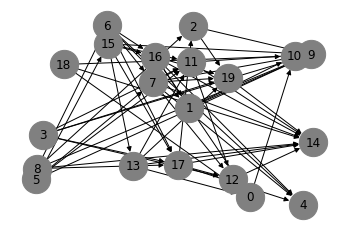

In [25]:
g_true = SpaceTime(Simulator.random(n_nodes, **graph_params))
data = Data(Simulator.sem(g_true.adj.numpy(), **data_params))

g_true.draw_graph()

In [18]:
def threshold(adj, threshold):
    return nn.Threshold(threshold, 0.0)(adj)-nn.Threshold(threshold, 0.0)(-adj)

In [19]:
g_test = SpaceTime(Simulator.random(5, **{'degree':2, 'graph_type':'erdos-renyi', 'w_range':(0.5, 2.0), 
                'force_positive':False, 'seed':101}))

simulating a random 2-degree erdos-renyi dag with range (0.5, 2.0) (seed 101)


In [20]:
col_plot_dict = {0:(4,2), 1:(4,1), 2:(2,1), 3:(3,0)}
mutilate = 1
observe = 2
latent = 0

In [21]:
####################################################################
### Ripped heavily from https://github.com/fishmoon1234/DAG-GNN
####################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalBlock(nn.Module):
    """SEM operator module."""
    def __init__(self, n_nodes, d_causal, vectorize=False, boost=False):
        super(CausalBlock, self).__init__()
        self.n_nodes = n_nodes
        self.adj = nn.Parameter(rand_norm(0, 1e-9, n_nodes, n_nodes).double(), requires_grad=True)
        
        norm_1, norm_2 = ortho_norm(1e-7, n_nodes, d_causal)
        self.q = nn.Parameter(norm_1.double(), requires_grad=True)
        self.k = nn.Parameter(norm_2.double(), requires_grad=True)
        
        self.vectorize = vectorize        
        self.boost = boost
    
    def forward(self, x):
        x = self.bmm(self.op().fill_diagonal_(0.0), x)
        return x
    
    def enc_sem(self, x):
        z = self.bmm(self.sem(), x)
        return z
    
    def dec_sem(self, x):
        x = self.bmm(self.sem().inverse(), x)
        return x
        
    def bmm(self, m, x):
        return torch.einsum('ij,ajc->aic', m, x)

    def op(self):
        return self.adj_p().transpose(-2,-1)
    
    def sem(self):
        return torch.eye(self.n_nodes).double()-(self.op().fill_diagonal_(0.0))
    
    def adj_p(self):
        if self.vectorize:
            return self.adj_vec()
        else:
            return self.adj_mat()
            
    def adj_vec(self):
        check_nan({'q':self.q, 'k':self.k})
        if self.boost:
            return torch.sinh(3*torch.matmul(self.q, self.k.transpose(-2,-1)))
        else:
            return torch.matmul(self.q, self.k.transpose(-2,-1))
        
    def adj_mat(self):
        check_nan({'adj':self.adj})
        if self.boost:
            return torch.sinh(3*torch.matmul(torch.eye(self.n_nodes).double(), self.adj))
        else:
            return torch.matmul(torch.eye(self.n_nodes).double(), self.adj)
        
class AutoEncoder(nn.Module):
    def __init__(self, n_nodes, d_causal, d_x, d_hid, d_z):
        super(AutoEncoder, self).__init__()
        self.embedder = LinearBlock(d_x, d_hid, d_z).double()
        self.debedder = LinearBlock(d_z, d_hid, d_x).double()
        self.causal = CausalBlock(n_nodes, d_causal, vectorize=False, boost=False).double()
            
    def encode(self, x):
        x = self.embedder(x)
#         x = self.causal.enc_sem(x)
        return x
    
    def decode(self, z):
        z = self.causal(z)
        z = self.debedder(z)
        return z

    def forward(self, x):
        z = self.encode(x)
        xx = self.decode(z)
        return xx, z, self.causal.adj_p()

In [22]:
model_params = {'n_nodes':n_nodes, 'd_causal':int(2*n_nodes), 
                'd_x':data_params['x_dims'], 'd_hid':64, 'd_z':data_params['x_dims']}

coeff_params = {'l_init':1e-2, 'c_init':1.0, 'tau_init':1e-9, 'tr_init':100.}
ctrl_params = {'gamma':0.25/(1), 'eta':10.0/(1)}
opt_params = {'warmups':0, 'lr_init':3e-3, 'h_tol':1e-9, 'max_iters':40}

train_params = {'batch_size':100, 'epochs':5}

In [23]:
import copy

def run_trials(data, n_trials):
    model_log = Logger('models')
    kinetic_log = Logger(*KineticLoss.params)
    interaction_log = Logger(*InteractionLoss.params)
    param_log = Logger(*Trainer.params)
    eval_log = Logger(*Validator.params)
    
    graphs = list()
    
    kinetic = KineticLoss()
    interaction = InteractionLoss.poly(n_nodes, Coefficients(**coeff_params))
    ctrl = Control(**ctrl_params)
    val = Validator(g_true)
    
    c = copy.deepcopy

    for n in range(n_trials):
        model = AutoEncoder(**model_params)
        loss = LagrangianLoss(kinetic=c(kinetic), interaction=c(interaction), 
                              ctrl=c(ctrl), opt=OptimAction(model, **opt_params))

        trainer = Trainer(model, loss, data, **train_params, val=c(val))
        trainer.train()
        
        model_log.append({'models':trainer.model})
        kinetic_log.append(trainer.kinetic_log.full())
        interaction_log.append(trainer.interaction_log.full())
        param_log.append(trainer.param_log.full())
        eval_log.append(trainer.val.log.full())
        
        graphs.append(trainer.loss.interaction.adj)
        
    mean_shd = [x[-1] for x in eval_log.log['shd']]
    mean_err = [x[-1] for x in eval_log.log['err']]

    print("Mean SHD: {:0.4f} +- {:0.4f}".format(np.mean(mean_shd), np.std(mean_shd)))
    print("Mean Err: {:0.4f} +- {:0.4f}".format(np.mean(mean_err), np.std(mean_err)))
        
    return model_log, kinetic_log, interaction_log, param_log, eval_log, graphs

In [26]:
model_log, kinetic_log, interaction_log, param_log, eval_log, graphs = run_trials(data, 2)

***Iteration: 0, Best Epoch: 4/5 || elbo: 10^2.315 || kl: 10^1.921 || nll: 10^2.090
     h: 10^-0.879 || l1: 10^1.635 || l: 10^-2.00 || c: 10^0.00 || lr: 10^-2.523
     shd: 58.000 || tpr: 0.482 || fpr: 0.216 || err: 12.540
***Iteration: 1, Best Epoch: 4/5 || elbo: 10^2.044 || kl: 10^1.593 || nll: 10^1.855
     h: 10^-0.437 || l1: 10^1.739 || l: 10^-0.85 || c: 10^0.00 || lr: 10^-2.523
     shd: 54.000 || tpr: 0.518 || fpr: 0.201 || err: 13.424
***Iteration: 2, Best Epoch: 4/5 || elbo: 10^1.877 || kl: 10^1.450 || nll: 10^1.673
     h: 10^-0.434 || l1: 10^1.769 || l: 10^-0.85 || c: 10^1.00 || lr: 10^-2.523
     shd: 52.000 || tpr: 0.536 || fpr: 0.194 || err: 13.953
***Iteration: 3, Best Epoch: 4/5 || elbo: 10^1.773 || kl: 10^1.378 || nll: 10^1.549
     h: 10^-0.685 || l1: 10^1.769 || l: 10^-0.85 || c: 10^2.00 || lr: 10^-2.824
     shd: 48.000 || tpr: 0.571 || fpr: 0.179 || err: 14.221
***Iteration: 4, Best Epoch: 4/5 || elbo: 10^1.750 || kl: 10^1.348 || nll: 10^1.532
     h: 10^-1.086 ||

***Iteration: 7, Best Epoch: 4/5 || elbo: 10^1.724 || kl: 10^1.246 || nll: 10^1.549
     h: 10^-2.273 || l1: 10^1.811 || l: 10^2.38 || c: 10^5.00 || lr: 10^-3.222
     shd: 34.000 || tpr: 0.696 || fpr: 0.127 || err: 15.914
***Iteration: 8, Best Epoch: 4/5 || elbo: 10^1.705 || kl: 10^1.208 || nll: 10^1.539
     h: 10^-2.513 || l1: 10^1.819 || l: 10^2.89 || c: 10^5.00 || lr: 10^-3.301
     shd: 34.000 || tpr: 0.696 || fpr: 0.127 || err: 16.246
***Iteration: 9, Best Epoch: 4/5 || elbo: 10^1.694 || kl: 10^1.174 || nll: 10^1.538
     h: 10^-2.893 || l1: 10^1.824 || l: 10^2.89 || c: 10^6.00 || lr: 10^-3.301
     shd: 32.000 || tpr: 0.714 || fpr: 0.119 || err: 16.604
***Iteration: 10, Best Epoch: 4/5 || elbo: 10^1.678 || kl: 10^1.142 || nll: 10^1.529
     h: 10^-3.138 || l1: 10^1.827 || l: 10^3.31 || c: 10^6.00 || lr: 10^-3.368
     shd: 28.000 || tpr: 0.750 || fpr: 0.104 || err: 16.880
***Iteration: 11, Best Epoch: 4/5 || elbo: 10^1.668 || kl: 10^1.112 || nll: 10^1.527
     h: 10^-3.534 || l

In [65]:
import seaborn as sns

def graph_temp(adj, n_nodes, ax):
    sns.heatmap(adj, xticklabels=range(n_nodes), yticklabels=range(n_nodes), 
                square=True, vmin=0.1, vmax=1.0, cbar=False, ax=ax)
    
def graph_trials(graphs):
    n_graphs = len(graphs)
    n_nodes = graphs[0].shape[-1]
    
    fig, axs = plt.subplots(1, n_graphs, figsize=(4*n_graphs, 4))
    for graph, ax in zip(graphs, axs):
        graph_temp(torch.abs(graph), n_nodes, ax)
    plt.show()
    
def logger_trials(logger):
    n_plots = len(logger.log)
    fig, axs = plt.subplots(1, n_plots, figsize=(4*n_plots, 2))
    for label, ax in zip(logger.log.keys(), axs):
        logger.plot(label, ax)
    plt.show()

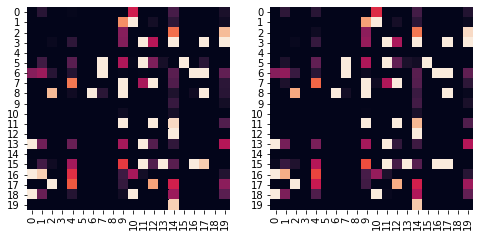

In [66]:
graph_trials(graphs)

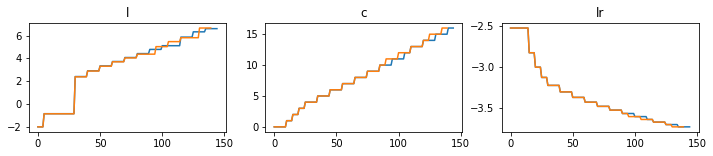

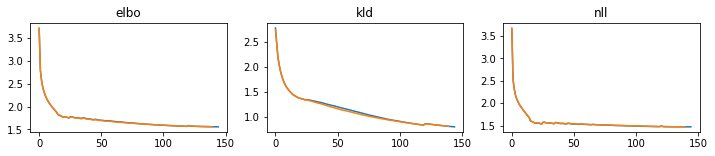

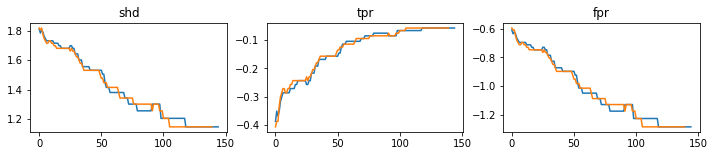

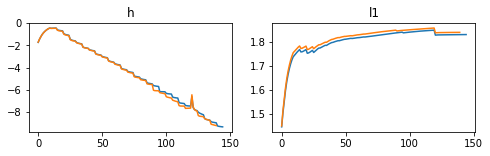

In [52]:
# interaction_log.log.update({'err':eval_log.log.pop('err')})
logger_trials(param_log)
logger_trials(kinetic_log)
logger_trials(eval_log)
logger_trials(interaction_log)

In [67]:
graphs[0][-5:,-5:]
graphs[-1][-5:,-5:]

tensor([[-5.0988e-20, -1.1285e+00, -9.2880e-01,  7.1009e-05, -3.1287e-02],
        [-1.3288e-07,  4.1424e-19, -4.6370e-02,  7.3550e-05,  1.8076e-01],
        [-2.1933e-07, -3.1130e-05,  1.7432e-19,  1.9746e-06,  4.1390e-01],
        [ 4.3272e-03, -7.1555e-03, -2.4275e-02,  2.2612e-20,  3.0794e-01],
        [ 7.8380e-07,  6.4331e-06,  8.7011e-07, -1.4666e-07,  1.0720e-18]],
       dtype=torch.float64)

tensor([[-1.6230e-19, -1.1664e+00, -1.0176e+00, -5.5625e-06,  2.4518e-02],
        [-1.2315e-07, -2.1404e-19, -3.4702e-02,  4.2933e-04,  1.9207e-01],
        [-1.8226e-07, -4.5278e-05, -2.0047e-16,  2.6439e-06,  4.5370e-01],
        [ 5.2837e-04, -4.1616e-04, -3.3137e-02, -1.5941e-19,  3.2782e-01],
        [ 5.9870e-07,  5.1562e-06,  6.2812e-07, -1.4423e-07,  6.3938e-19]],
       dtype=torch.float64)

In [ ]:
_, test_loader = data.loader(500)
test_loader = iter(test_loader)
test_data = next(test_loader)[0]
xx, z, adj = model_log.log['models'][-1](test_data.double())  
test_data[:1,:7,:]
z[:1,:7,:]
xx[:1,:7,:]

In [ ]:
_, test_loader = data.loader(500)
test_loader = iter(test_loader)
test_data = next(test_loader)[0]
xx, z, adj = model_log.log['models'][-2](test_data.double())  
test_data[:1,:7,:]
z[:1,:7,:]
xx[:1,:7,:]

In [ ]:
blah

## SEM Evaluation

In [ ]:
g_learned = SpaceTime.adjacency(optimizerL.show_adj(0.2).numpy())
g_learned.draw_graph()

In [ ]:
data, _ = next(testdata)
preds, z_train, origin_A = autoencoder(data.double()) 

In [ ]:
autoencoder.eval()

data = next(iter(test_loader))[0].double()
preds, noise, _ = autoencoder(data.double()) 
pass;

In [ ]:
X_train = NodeData(g.data, bins=10)
XX_train = NodeData(preds.detach().numpy(), bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pXX_train = GraphSampler(g, XX_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [ ]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

In [ ]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [ ]:
preds_resampled_cdf = autoencoder.decode(torch.Tensor(Z_resampled_cdf.data()).double())
preds_resampled_pdf = autoencoder.decode(torch.Tensor(Z_resampled_pdf.data()).double())
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=X_train.edges())
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=X_train.edges())

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

In [ ]:
fig, axs = plt.subplots(2, 4, sharex='col', sharey='col', figsize = (16,6))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
#     axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
#     axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (preds histo)'%(d,c))
    axs[1][col].contour(*pXX_train.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [ ]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [ ]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

In [ ]:
blah

## Graph Mutilation Tests

In [ ]:
sim_mutil = Simulator(g.mutilate(mutilate).numpy())
sim_mutil.sem(7500, 'nonlinear_2')
g_mutil = SpaceTime.simulation(sim_mutil)
g_mutil.adj
g_mutil.draw_graph()

In [ ]:
g_learned.draw_graph()

g_learned_mutil = SpaceTime.adjacency(g_learned.mutilate(mutilate).numpy())
g_learned_mutil.draw_graph()

In [ ]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [ ]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

In [ ]:
preds_resampled_mutil_cdf = autoencoder.decode(torch.Tensor(Z_resampled_mutil_cdf.data()).double(), 
                                       g_learned_mutil.adj, Wa_train)
preds_resampled_mutil_pdf = autoencoder.decode(torch.Tensor(Z_resampled_mutil_pdf.data()).double(), 
                                       g_learned_mutil.adj, Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

In [ ]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

In [ ]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

In [ ]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

In [ ]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;